# Mean–Variance Portfolio Optimiser & Back‑Test  
---
<br>

### TL;DR
Given 20 Global Equities, Bonds, and Commodities ETFs, <br>

uses portfolio optimization to create optimal portfolios <br>

with varying risk-tolerances, backtested on training data <br>

and test data, and evaluated via Sharpe-Ratio <br>
<br>

### Potential Future Additions:
- compare with monthly-rebalancing

- add constraints and find solution via CVXPY or other solver

In [2]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
tickers = [
    "VT",
    "VEU",
    "ACWI",
    "VWO",
    "EFA",
    "IEFA",
    "SPDW",
    "IXUS",
    "URTH",
    "BNDX",
    "IGOV",
    "BWX",
    "EMB",
    "VWOB",
    "IBND",
    "GLD",
    "SLV",
    "DBC",
    "PDBC",
    
    "SHV" # proxy for risk free asset
]
num_assets = len(tickers)

In [4]:
start = dt.date(2014, 1, 1)
end = dt.date(start.year + 5, start.month, start.day)

In [5]:
df = yf.download(tickers, start=start, end=end)["Close"]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed


In [6]:
df

Ticker,ACWI,BNDX,BWX,DBC,EFA,EMB,GLD,IBND,IEFA,IGOV,IXUS,PDBC,SHV,SLV,SPDW,URTH,VEU,VT,VWO,VWOB
Date,,,,,,,,,,,,,,,,,,,,
2014-01-02,45.124050,36.883091,25.374350,22.100721,46.874809,62.841496,118.000000,32.745960,42.547646,48.092701,41.111973,NaN,91.267738,19.230000,20.730097,55.773895,35.312141,45.423515,28.672766,44.058914
2014-01-03,45.100224,36.853386,25.312439,21.960896,46.924580,62.899628,119.290001,32.611069,42.597572,47.861984,41.119236,NaN,91.284325,19.420000,20.751675,55.773895,35.312141,45.470093,28.636660,44.081955
2014-01-06,44.957218,36.942547,25.422993,21.987114,46.867691,63.149391,119.500000,32.826912,42.590443,48.006180,41.046535,NaN,91.276047,19.420000,20.751675,55.300766,35.233994,45.345890,28.362207,44.179920
2014-01-07,45.195549,37.031685,25.440691,21.969635,47.130825,63.230736,118.820000,32.701000,42.811565,47.953304,41.177402,NaN,91.276047,19.129999,20.837988,55.990410,35.397392,45.555470,28.477762,44.231823
2014-01-08,45.179657,36.942547,25.347809,21.759903,47.116604,62.882206,118.120003,32.593086,42.747364,47.866787,41.199203,NaN,91.284325,18.830000,20.794834,55.854092,35.361862,45.563229,28.427202,44.105007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,54.245388,44.587513,25.061590,12.738640,46.871326,75.936630,120.019997,30.161970,43.559216,47.610817,42.196201,7.779101,93.825928,13.870000,21.164354,67.024750,36.452450,54.447811,30.788618,53.181232
2018-12-26,56.249218,44.546326,25.015871,13.021917,47.958870,76.047310,119.660004,29.968081,44.626442,47.393681,43.175392,7.929598,93.825928,14.110000,21.659618,69.221992,37.293095,56.474411,31.333120,53.238716
2018-12-27,56.515224,44.571045,25.107292,12.897983,48.098930,76.364632,120.570000,30.245058,44.716747,47.531857,43.117298,7.851755,93.868477,14.300000,21.659618,69.909744,37.334297,56.788902,31.267122,53.396809


In [7]:
returns_df = df.pct_change().dropna()
returns_df.head()

Ticker,ACWI,BNDX,BWX,DBC,EFA,EMB,GLD,IBND,IEFA,IGOV,IXUS,PDBC,SHV,SLV,SPDW,URTH,VEU,VT,VWO,VWOB
Date,,,,,,,,,,,,,,,,,,,,
2014-11-10,0.002189,0.000381,-0.002483,-0.009554,0.004455,-0.001233,-0.022218,-0.003148,0.004734,-0.002874,0.003450,-0.005148,0.00009,-0.011921,0.003602,0.002494,0.003927,0.002964,0.000718,0.000507
2014-11-11,0.003360,-0.000191,0.002133,0.005053,0.006019,-0.000528,0.014304,0.004593,0.005758,0.002677,0.005429,0.000000,0.00000,0.012735,0.005025,0.004561,0.004734,0.002627,0.001673,-0.000887
2014-11-12,-0.003181,0.000382,-0.001596,-0.003199,-0.008502,0.000352,-0.004820,-0.002000,-0.008154,-0.002669,-0.005940,-0.000796,0.00000,-0.005295,-0.004643,-0.002339,-0.005736,-0.002456,-0.002863,0.000634
2014-11-13,0.001512,0.000191,0.000888,-0.018340,0.004764,-0.000529,0.001525,0.002862,0.004548,0.000618,0.000905,-0.021514,0.00000,-0.003992,0.001076,-0.003309,0.001854,-0.000328,-0.002393,-0.003548
2014-11-14,0.001342,0.000764,0.002308,0.010743,0.001423,-0.000794,0.025074,0.003997,0.001219,0.004218,0.003618,0.000000,0.00000,0.044088,0.002150,0.004427,0.003702,0.002627,0.010554,-0.000255


\begin{aligned}

    &\text{Given a matrix of }n\text{ risky asset returns over }m\text{ periods } R \in \mathbb{R}^{m\times n} \text{ where }R_{i, j} \text{ is the return of asset } j \text{ on day } i \text{ and portfolio } x \in \mathbb{R}^n \\[6pt]
    & \text{and risk-free return } r_f \text{ with allocation } x_f \in \mathbb{R}\\[10pt]
     
    &\text{Portfolio Returns = }Rx + r_fx_f \\[6pt]
    &\text{Portfolio Variance = }x^T\Sigma x \text{, where } \Sigma \text{ is the covariance of returns for each of the } n \text{ assets} \\[6pt]
    &\text{Define }\mathbb{E}[R] = \mu\\[20pt]

    &\textbf{Optimization Setup:} \\[6pt]
    &\max_{x, \ x_f} \quad \quad \quad \quad \mu^T x + r_fx_f - \lambda x^T \Sigma x \\
    &\text{ subject to } \quad \ \ \textbf{1}^Tx + x_f = 1 \\[15pt]

    &\text{substitute } x_f = 1 - \textbf{1}^Tx \implies \max_{x} \quad (\mu^T  - \textbf{1}^T r_f)x - \lambda x^T \Sigma x + r_f\\
    &\text{solve via Lagrangian: }\quad \mathcal{L}(x) = (\mu^T  - \textbf{1}^T r_f)x - \lambda x^T \Sigma x + r_f\\
    &\text{take the partial: }\quad \frac{\partial \mathcal{L}}{\partial x} = \mu^T - \textbf{1}^Tr_f - 2 \lambda \Sigma x\\
    &\text{set equal to }0 \implies x^* = \frac{1}{2\lambda}\Sigma^{-1}(\mu^T - \mathbf{1}^Tr_f)

\end{aligned}

In [8]:
returns_cov_df = returns_df.cov()
returns_cov = returns_cov_df.reset_index().drop("Ticker",axis=1).to_numpy()
returns_cov_inv = np.linalg.inv(returns_cov)
returns_cov_inv.shape

(20, 20)

In [9]:
returns = returns_df.reset_index().drop("Date",axis=1).to_numpy()
mu = np.mean(returns, axis=0)
mu

array([ 2.03880036e-04,  1.22429508e-04,  1.34063132e-05, -3.36470438e-04,
        9.69713652e-05,  1.18403647e-04,  1.02439301e-04, -2.69024762e-05,
        1.24701456e-04,  2.23069723e-05,  1.09519651e-04, -3.32137410e-04,
        2.67135051e-05,  5.15072003e-05,  1.08474695e-04,  2.14572143e-04,
        1.05454362e-04,  2.05380177e-04,  8.80434468e-05,  1.27861336e-04])

In [10]:
tickers_alphabetical = np.array(returns_df.columns)
index_of_rf_asset = np.where(tickers_alphabetical == ("SHV"))[0][0] # SHV is risk free proxy
index_of_rf_asset

rf_portfolio = np.zeros(num_assets)
rf_portfolio[index_of_rf_asset] = 1

In [11]:
lambda_values = [0.5, 1, 2, 5, 10, 25, 50, 100]
n_assets = len(tickers)

portfolios = []

for lamb in lambda_values:
    x = 1 / (2 * lamb) * returns_cov_inv @ (mu - np.ones(n_assets) * mu[index_of_rf_asset])
    portfolios.append(x)

In [12]:
def portfolio_value(V_0, returns, x):
    daily_returns = returns @ x
    wealth = V_0 * np.cumprod(1.0 + daily_returns)
    return wealth
portfolio_value(1, returns, x)

array([1.00009248, 1.00009029, 1.00041543, ..., 1.05450842, 1.0550234 ,
       1.05611884], shape=(1042,))

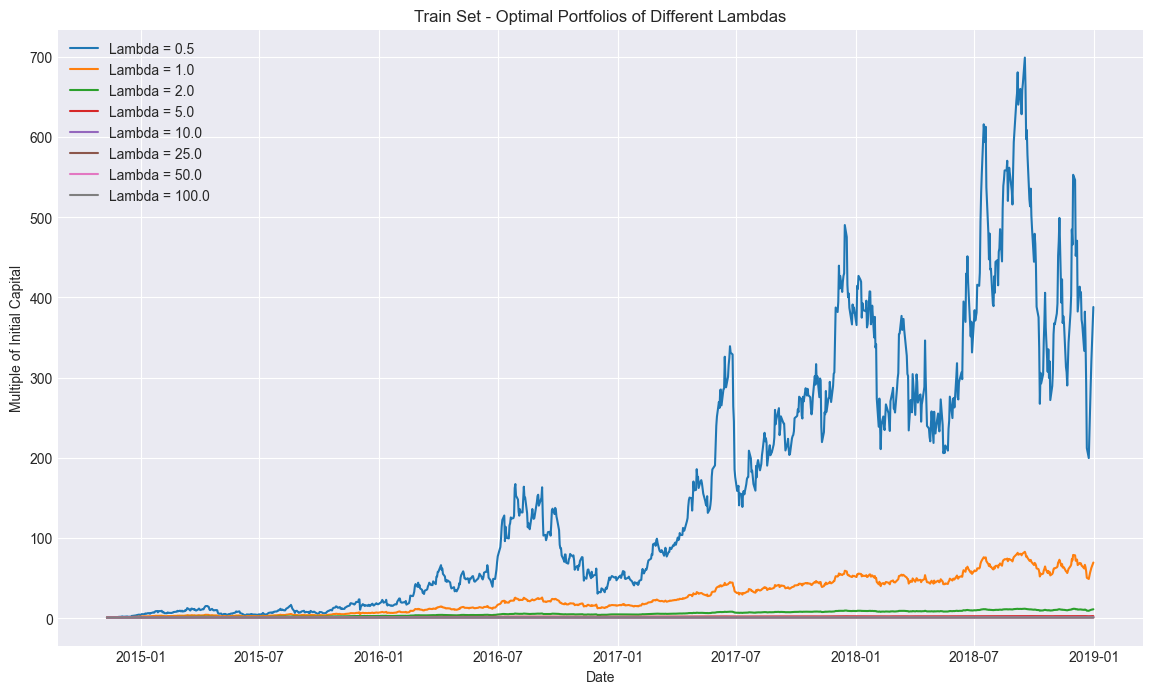

In [13]:
plt.figure(figsize=(14, 8))
plt.style.use("seaborn-v0_8-darkgrid")

for x, lamb in zip(portfolios, lambda_values):
    plt.plot(returns_df.index, portfolio_value(1, returns, x), label=f"Lambda = {lamb:.1f}")

plt.title("Train Set - Optimal Portfolios of Different Lambdas")
plt.xlabel("Date")
plt.ylabel("Multiple of Initial Capital")
plt.legend();

In [14]:
start = dt.date(end.year, 1, 1)
end = dt.date(start.year + 1, start.month, start.day)
test_df = yf.download(tickers, start=start, end=end)["Close"]

test_returns_df = test_df.dropna(axis=1).pct_change().dropna(axis=0)
test_returns_df.head()

[*********************100%***********************]  20 of 20 completed


Ticker,ACWI,BNDX,BWX,DBC,EFA,EMB,GLD,IBND,IEFA,IGOV,IXUS,PDBC,SHV,SLV,SPDW,URTH,VEU,VT,VWO,VWOB
Date,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.016994,0.000000,0.004348,0.008259,-0.009035,0.004234,0.009066,0.000306,-0.006569,0.006818,-0.008400,0.007275,0.000362,0.013049,-0.008709,-0.016734,-0.009883,-0.015601,-0.015678,0.002675
2019-01-04,0.031880,-0.000921,-0.000721,0.013652,0.030621,0.007572,-0.008086,0.002757,0.030309,-0.001437,0.030420,0.014445,0.000272,-0.001356,0.031322,0.030428,0.030834,0.032473,0.031590,0.002536
2019-01-07,0.006148,-0.002396,0.001805,0.007407,0.003839,0.004280,0.003458,0.007025,0.004814,0.002877,0.004111,0.007767,0.000000,-0.004073,0.004074,0.004630,0.003228,0.006170,0.002059,0.003460
2019-01-08,0.007333,-0.000739,-0.002883,0.010027,0.006485,-0.000758,-0.002708,-0.008493,0.007097,-0.005123,0.006327,0.008349,-0.000090,0.001363,0.006271,0.009839,0.006220,0.008077,0.005650,0.000000
2019-01-09,0.009251,0.000555,0.008313,0.019854,0.011234,0.001801,0.006418,0.010094,0.010747,0.009063,0.013499,0.021019,-0.000090,0.006127,0.013196,0.006907,0.013430,0.009347,0.014556,0.001459


In [15]:
test_returns = test_returns_df.reset_index().drop("Date",axis=1).to_numpy()
test_returns

array([[-0.01699412,  0.        ,  0.00434758, ..., -0.01560074,
        -0.01567847,  0.00267483],
       [ 0.03187966, -0.00092059, -0.00072132, ...,  0.03247328,
         0.03159035,  0.00253559],
       [ 0.00614788, -0.00239561,  0.00180525, ...,  0.0061701 ,
         0.00205864,  0.00345966],
       ...,
       [ 0.0006289 ,  0.        ,  0.00384241, ...,  0.00123283,
         0.00134709,  0.00394164],
       [-0.006034  , -0.00193952, -0.00139156, ..., -0.00591031,
        -0.00560444, -0.00208598],
       [ 0.00227662, -0.00035346,  0.00383246, ...,  0.00322045,
         0.00247972,  0.00098417]], shape=(251, 20))

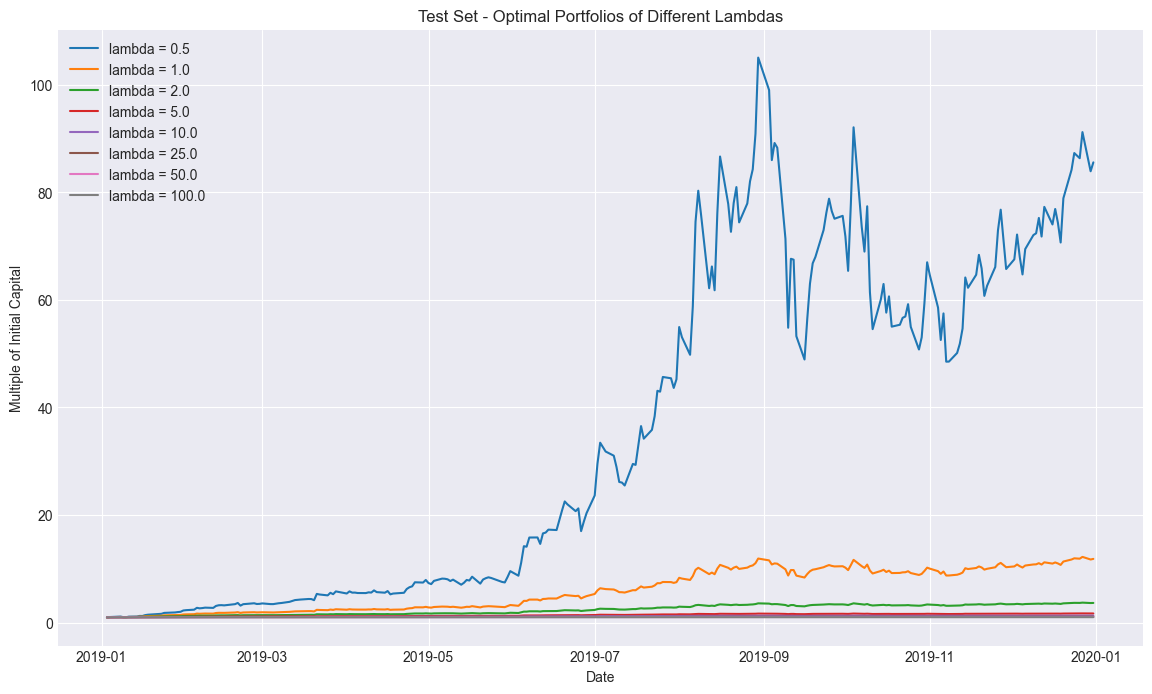

In [16]:
plt.figure(figsize=(14, 8))
plt.style.use("seaborn-v0_8-darkgrid")

for x, lamb in zip(portfolios, lambda_values):
    plt.plot(test_returns_df.index, portfolio_value(1, test_returns, x), label=f"lambda = {lamb:.1f}")
plt.legend()

plt.title("Test Set - Optimal Portfolios of Different Lambdas")
plt.xlabel("Date")
plt.ylabel("Multiple of Initial Capital")
plt.legend();

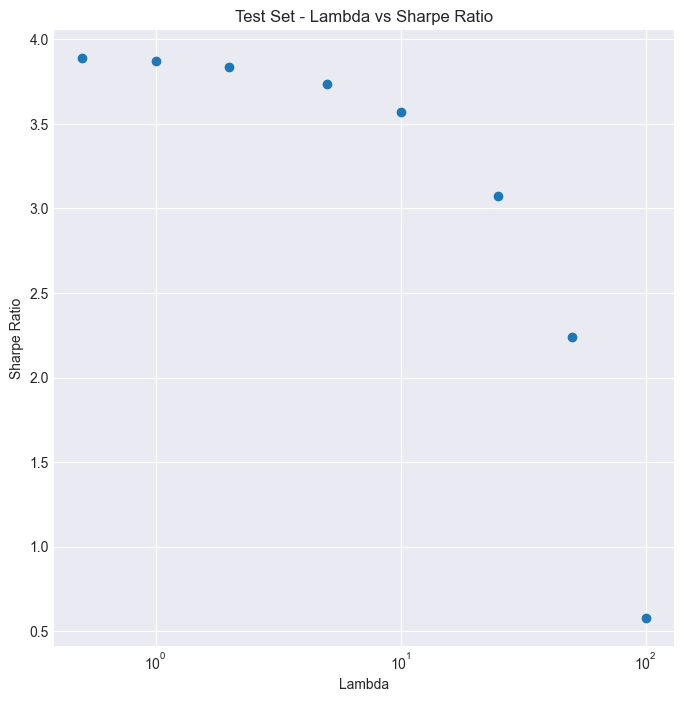

In [17]:
def annual_returns(returns, portfolio):
    TRADING_DAYS = 252
    return TRADING_DAYS * (returns @ portfolio).sum() / len(returns @ portfolio)
def annual_risk(returns, portfolio):
    TRADING_DAYS = 252
    return np.std(returns @ portfolio) * np.sqrt(TRADING_DAYS)
def sharpe_ratio(returns, portfolio):
    return (annual_returns(returns, portfolio) - annual_returns(returns, rf_portfolio)) / annual_risk(returns, portfolio)

sharpe_values = []
for portfolio in portfolios:
    sharpe_values.append(sharpe_ratio(test_returns, portfolio))

plt.figure(figsize=(8, 8))

plt.scatter(lambda_values, sharpe_values)
plt.xscale('log')

plt.xlabel("Lambda")
plt.ylabel("Sharpe Ratio")
plt.title("Test Set - Lambda vs Sharpe Ratio");

In [19]:
sharpe_values[0]

np.float64(3.887959455913675)